# 0 - Overview and setup

In these notebooks we are going to present an introduction to machine learning. We are going start by demonstrating how to fit a line to a series of points, and finishing by identifying a collection of handwritten digits. This may not sound much like AI, but the foundational concepts we will go through can be extended to surprisingly complicated tasks. 

We will be using the [tensorflow](https://www.tensorflow.org/get_started/get_started) framework, which we will introduce later.

First, we are going to check that all the modules we require are within the environment. We are going to use Python 3 in all the notebooks, so please ensure that you have this installed. 

In [2]:
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
assert sys.version_info.major == 3

Now we are going to set the random seed. This will ensure that we can obtain reproducible results each time we run the notebook.

In [3]:
np.random.seed(0)

# 1 - Linear regression
### 1.1 - Introduction

Fundamentally what we are interested in is making predictions. Suppose I have a list of different houses and a description of each with their location, number of rooms, floorspace, etc, and I also have the corresponding price they were sold for. What I would like is to be able to give my machine learning system a new house description and have it accurately predict how much it sold for.

We can think of the description of the house as an input, and the price as the output. We then have {input, output} pairs which we can use to develop our system. This type of problem, where we have known outputs is called **supervised learning**, and when our outputs are real-valued numbers, we can use **linear regression** to build the system.

### 1.2 - Simple example

Suppose you are a physicist and you are collecting data from an experiment. Specifically, every hour you measure the temperature of a bar that is being slowly heated. 

We will record this as a series of $(x, y)$ pairs where $x \in [0 .. 19]$ is the hour after the experiment start, and $y$ is the temperature of the bar. We will artifically generate the datapoints below.

In [4]:
x_vals = np.arange(20).reshape(-1, 1) # This turns x into a column vector of shape 20x1.
y_true_vals = [5*x for x in x_vals] # Generate underlying values
y_noisy_vals = np.random.normal(y_true_vals, scale=3.0) # Add gaussian noise to each point

Now we will plot the data to check that it is sensible.

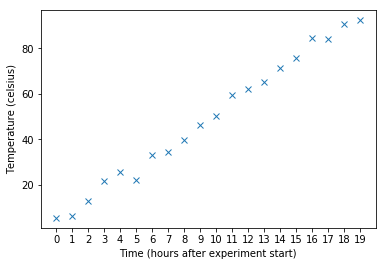

In [5]:
fig_1 = plt.figure()
ax_1 = fig_1.add_subplot(1, 1, 1)
ax_1.plot(x_vals, y_noisy_vals, 'x')
ax_1.set_xticks(x_vals)
ax_1.set_xlabel('Time (hours after experiment start)')
ax_1.set_ylabel('Temperature (celsius)')
display(fig_1)

Ok. This looks like it could be real data. There seems to be a general trend, and we can see that there were perhaps some mistakes made when taking the measurement. Now, let's fit a function to this data.

Our function is going to take the form:

$$\hat{y} = w_1 x$$

Which means that for an input $x$, we will predict some output $\hat{y}$, based on the value of $w_1$. We will call this our "predicting function". The term $w_1$ is what we will call a **weight**, and we are going to try and learn its value.

N.B You may wonder why we are fitting _this_ function to the data. How do we know there's not a more complex function that might fit the data better? This is a valid point, and the most straightforward answer is that we tend to prefer simple equations to more complex ones. The reason for this is that simpler equations tend to be more _generalisable_ which we will talk about later in the notebook.

We need a way to measure how "good" our function is, and for that we define something called the **loss**. This is some measure of the difference between the _true_ data, and our _predicted_ values. We are going to measure the L2 loss which we will define as:

$$\mathcal{L}_2 = \frac{1}{2n}\sum_{i=0}^{n}(\hat{y}_i - y_i)^2$$

That is, for every input $x$, we take the squared difference between our prediction, $\hat{y}$, and the true value $y$, and sum these values. We also divide by twice the number of datapoints, this stops the loss growing too rapidly, and makes it slightly easier to handle numerically.

In code:

In [6]:
def L2_loss_example(y_pred, y):
    return np.sum((y_pred-y)**2) / (2 * y_pred.shape[0])

We want to minimise this loss. Let's pause for a moment, because we are going to introduce a very important concept: the loss function.

---

If we observe the equation above, we note that the L2 loss is itself a function! Specifically, it is parameterised by $w_1$. So we have a function that we are trying to minimise. We will call this the loss function.

Let's step through this with an example. We are going to select a range of different values for $w_1$ and observe the loss function evaluated at these values. This is what's called a **grid search**.

In [7]:
w1_values = np.linspace(0, 10, 19)

loss_function_values = []
for w1 in w1_values:
    y_pred = w1 * x_vals # this is our predicting equation from above
    loss_function_values.append(L2_loss_example(y_pred, y_noisy_vals))
    print("w1: {:.2f}, Loss function: {:.2f}".format(w1, L2_loss_example(y_pred, y_noisy_vals)))

w1: 0.00, Loss function: 1599.74
w1: 0.56, Loss function: 1270.04
w1: 1.11, Loss function: 978.47
w1: 1.67, Loss function: 725.01
w1: 2.22, Loss function: 509.67
w1: 2.78, Loss function: 332.44
w1: 3.33, Loss function: 193.33
w1: 3.89, Loss function: 92.34
w1: 4.44, Loss function: 29.47
w1: 5.00, Loss function: 4.71
w1: 5.56, Loss function: 18.07
w1: 6.11, Loss function: 69.55
w1: 6.67, Loss function: 159.15
w1: 7.22, Loss function: 286.86
w1: 7.78, Loss function: 452.69
w1: 8.33, Loss function: 656.64
w1: 8.89, Loss function: 898.70
w1: 9.44, Loss function: 1178.88
w1: 10.00, Loss function: 1497.18


Now let's plot the values of the loss function, for the different values of $w_1$.

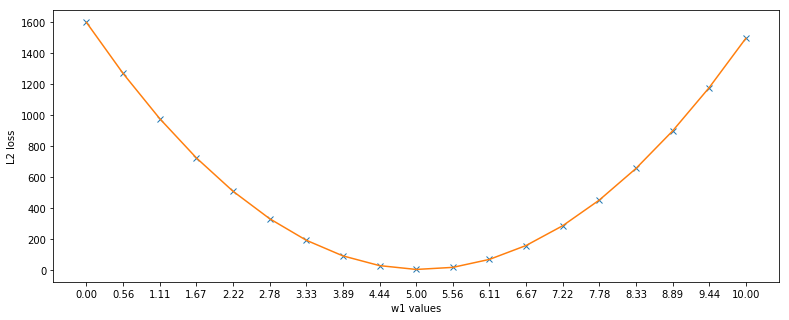

In [8]:
fig_2 = plt.figure(figsize=(13,5))
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(w1_values, loss_function_values, 'x')
ax.plot(w1_values, loss_function_values)
ax.set_xticks(w1_values)
ax.set_xlabel("w1 values")
ax.set_ylabel("L2 loss")
display(fig_2)

And select the minimum value for $w_1$:

In [9]:
lowest_index = (np.argmin(loss_function_values))
print("Value of w1 where loss is minimised: {}".format(w1_values[lowest_index]))

Value of w1 where loss is minimised: 5.0


Great! We now have our predicting function:

$$y = 5x$$

If we look at where we generated the artificial data, we indeed find that our underlying equation (before we added the noise) was $y = 5x$, and we have been able to learn this equation from the data. That's us right? Now we can conquer machine learning with our regression model!

Not quite. We were lucky that our range of $w1$ values happened to include the minimum. What if we'd only looked at values $\in [0, 3]$? We need a more robust technique.

### 1.3 - Gradient descent

Now, we are going to take a pretty big jump. I'll try and explain this as simply as possible, because there are going to be quite a lot of new concepts.

Imagine you are a small man that lives in your computer screen, and you are currently stuck on the plot above, where $w_1$ = 0.0. Suppose I tell you that I'll let you escape if you can find the minimum value of $w_1$ for me. What would you do? You would simply walk down the orange line of the graph until you reached the bottom. Congratulations! You're free! That's what gradient descent does, at least at a cartoon level.

Specifically gradient descent computes the derivative (gradient) of the slope of the loss function and moves the $w_1$ value accordingly. This process is repeated until we reach a (local) minima.

![Grad_desc](https://cdn-images-1.medium.com/max/1600/1*ZmzSnV6xluGa42wtU7KYVA.gif)

This gif is taken from [this](https://hackernoon.com/life-is-gradient-descent-880c60ac1be8) more complete walk-through of gradient descent, and is certainly worth reading.

Gradient descent is an iterative algorithm, which takes 'steps' down the slope, and updates the weight parameters as it goes. In our case:

$$w_1 \leftarrow w_1 - \alpha \frac{d\mathcal{L}_2(w_1)}{dw_1}$$

This step would be repeated until convergence.

The $\alpha$ term is called the 'learning rate' or 'step size', and this is something we set. It controls how much of a step we take at each update. In ML we refer to this as a 'hyperparameter'. That is, it is a parameter of the model, but we set its value, whereas the weight paramaters of the model are learned. Usually, this value will be set to some small value such as 0.001, however in practice this will need to be tuned.

If you recall from calculus classes, we can compute the gradient numerically as follows:

$$\frac{df}{dx} \approx \frac{f(x + \epsilon) - f(x - \epsilon)}{2\epsilon}$$ where, in the limit of $\epsilon$ we obtain the true derivative. Let's write a function to compute this.

In [10]:
def numerical_gradient(f, x):
    eps = 1e-9 # some small floating point value
    return (f(x + eps) - f(x - eps))/ (2 * eps)

So what we want to do at each step is evaluate: 

$$\frac{\mathcal{L}_2(w_1 + \epsilon) - \mathcal{L}_2(w_1 - \epsilon)}{2\epsilon}$$

We are now going to modify our L2 code function from before to make this step slightly clearer:

In [11]:
def L2_loss(w):
    global x_vals
    global y_noisy_vals
    
    return np.sum((w * x_vals - y_noisy_vals)**2)/(2 * y_noisy_vals.shape[0])

# Sanity check
for w1 in [-1, 0, 1]:
    y_pred = w1 * x_vals
    assert L2_loss(w1) == L2_loss_example(y_pred, y_noisy_vals)

Ok! Let's do some gradient descent. One final thing to note is that the weight needs to be **initialised**. This is an active research topic at present in ML, and far outside the scope of this notebook. A rule of thumb is that you **NEVER** initialise weights to 0, rather initialise them to some small random number (see [here](http://cs231n.github.io/neural-networks-2/#init) for detail).

What we will do is select a random initialisation and perform gradient descent from that starting point. Also, we will choose four different learning rates, so in total, we will estimate four different models.

In [22]:
learning_rates = [0.0001, 0.001, 0.01, 0.1] # Learning rates
initialisation = -2.55 # This is hardcoded to be the same random number on all workbooks
w_old = None


w_1 = initialisation
for j, learning_rate in enumerate(learning_rates):
    w_1_vals = [w_1]
    total_iterations = 0
    print("Init: {:.2f}, Learning rate: {}".format(initialisation, learning_rate))
    # we will keep taking steps until we converge
    # which we will define as the value of our weight
    # does not change beyond some small value
    while True:
        w_old = w_1
        w_1 = w_1 - learning_rate * numerical_gradient(L2_loss, w_1) # this is our update step
        total_iterations += 1
        w_1_vals.append(w_1)
        
        if np.abs(w_1 - w_old) < 1e-6:
            print("I found the minimum at: w1 = {}".format(w_1))
            print("It took: {} iterations".format(total_iterations))
            print("----------------")
            break

Init: -2.55, Learning rate: 0.0001
I found the minimum at: w1 = 5.082961613124323
It took: 923 iterations
----------------
Init: -2.55, Learning rate: 0.001
I found the minimum at: w1 = 5.083034779042092
It took: 19 iterations
----------------
Init: -2.55, Learning rate: 0.01
I found the minimum at: w1 = 5.083041373766858
It took: 3 iterations
----------------
Init: -2.55, Learning rate: 0.1
I found the minimum at: w1 = 58110198.617416054
It took: 15 iterations
----------------


And that's gradient descent! It all looks fantast-- hmm. That's not right. What happened in the last model?

Well, if we set our learning rate too high, and we have a large gradient, then we will take a large step and we may overshoot our minima. We then take another large step and overshoot it _again_. This process will keep repeating, and we may never converge, or we may end up taking the derivative of a near vertical slope which (due to numerical issues) will return a gradient of 0, and the algorithm will terminate.

The lesson here is: start with a small learning rate, and adjust it carefully.

We can see that in three of the models we converged on an optimum value $w_1\approx 5.083$. This is very close to the value we found in grid search, however because we are not constrained to just choosing values in the grid, we are able to obtain a more acurate answer.

### 1.5 - Recap
Ok! We've done quite a lot so far. Who would have thought fitting a line could be so much work!

Before we dive into TensorFlow, we'll recap what we've done to give you an anchor.

1. We have some data, and we want to fit a function to that data.
    - We want to do this so that given some (possibly unseen) input, we can make a prediction based on our function.
2. We need a measure of how 'good' our function is.
3. We measure how good our function is by a separate loss function.
    - In our case we used L2 loss, the sum of the squared differences.
4. The minimum of the loss function gives the optimum values of the weights we should use.
5. We can find this minimum of the loss by a procedure called "gradient descent".

The next notebook will introduce the TensorFlow framework.

In [27]:
# OPTIONAL:

# Try fitting your own randomly generated data to make sure you understand what's going on.

### YOUR CODE HERE ###